# Director of Dashboards and Data Access Performance Tasks 
Hello and thank you for your time! Below I will be answering the performance task questions for the Director of Dashboards and Data Access position at NOLAPS using Python and Pandas. I am performing the analysis inside of a Jupyter Notebook because it allows me to break down my thought process step by step by including markdown text like this as well as using comments in the code to explain what I'm doing. We could answer a lot of these questions with Excel Pivot Tables (and most of the time that's perfectly ok!). However, I'm choosing to do it this way because it gives me a chance to show off my Python coding skills, and I personally think it's the most fun.

You can find this file, a PDF version, an HTML version and all associated files that I produced to answer these questions at [https://github.com/antonoverby/nolaps-tryouts](https://github.com/antonoverby/nolaps-tryouts)

Please reach out and let me know how I did! 
Anton Overby, antonoverby@gmail.com, 504-351-0538 

## Preparation
### Preparing the virtual workspace
- Make directory
- Make virtual environment
- Install libraries
	- pandas
	- plotly
	- streamlit
	- geopandas
- Housekeeping
	- .gitignore
	
### Research 
- Working with geospatial data in Python
	- Geopandas:
		- https://geopandas.org/en/stable/getting_started/introduction.html
		- https://geopandas.org/en/stable/docs/user_guide/io.html
	
### Sandboxing
- Jupyter notebooks
	- map-sandbox.ipynb
	- portfolio.ipynb

### File Analysis
- Key: Site Code
	- Site Code (School)- data-analysis/2023-school-performance-scores.xlsx
	- SIS Submit Site Code (Total by Site)- data-analysis/oct-2023-multi-stats-(total-by-site-and-school-system)_web.xlsx
	- Accountability Record: Site Code - data-analysis/Portfolio Data.csv

### TO DO
- [x] sandbox analysis to answer questions
	- Read in files
- [x] visualizations
- [] data explorer streamlit app

## Performance Tasks and Accompanying Code
Before we do anything we're going to import Pandas, read in the files that we'll be working with, and perform any maintenance steps necessary.

In [233]:
import pandas as pd

'''Portfolio Dataframe'''

# Read files into Pandas Dataframes 
portfolio = pd.read_csv("data/Portfolio Data.csv", encoding='latin-1') # This one is pretty straight forward

'''Stats Dataframe'''
# This Dataframe is going to take some maintenance because the file has an image at the top, merged cells, headers are on differnt rows, etc. 
stats = pd.read_excel('data/oct-2023-multi-stats-(total-by-site-and-school-system)_web.xlsx', sheet_name='Total by Site', header=None, skiprows=3) # First read in the file with no header 
#and skip the rows containing the picture

stats.columns = stats.iloc[0] # set column names to first row
stats = stats[1:] # drop first row which is now the headers

# stats.rename(columns={stats.columns[stats.columns.isna()][0]: '% Male'}, inplace=True) #### <-- This is one way I tried that wasn't an ideal solution

first_row = stats.iloc[0] # Now identify the headers which were on the second row (now on the first row)

# The next line of code I'll admit I had to ChatGPT, but what it does is look and see if the header has a name or not
# if the header doesn't have a name then it takes the value of the cell right underneath. If there's no value in the 
# cell beneath the header then the header value stays

new_headers = [first_row[i] if not pd.isna(first_row[i]) else stats.columns[i] for i in range(len(stats.columns))]
stats.columns = new_headers # Set the column names
stats = stats.iloc[3:] # Start the dataframe at the first row of actual data

'''SPS Scores Dataframe'''
# This excel sheet is mercifully easier to read in than the last

sps = pd.read_excel('data/2023-school-performance-scores.xlsx', sheet_name='School', skiprows=3)

# The one thing we noticed is that there's a key in bottom rows that we don't need to include
sps = sps.iloc[0:1252]

# There's a warning below, but it does not stop the code from running. 
# This is an example of technical debt which will need to be addressed in a future draft


/tmp/ipykernel_76939/3373503214.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_headers = [first_row[i] if not pd.isna(first_row[i]) else stats.columns[i] for i in range(len(stats.columns))]


### Analysis 
#### 1) Which Schools have a Desired Enrollment that is greater than the facility's capacity? Are any schools over capacity? Please omit private facilities from this answer.

In [234]:
# First we're going to define the Enrollment Dataframe which uses only the columns we want 

enrollment = portfolio[['Accountability Record: Site Code', 'Accountability Record: Site Name','Facility: Facility Name', 'Students', 'Desired Enrollment', 'Facility Capacity']]

# We're then going to use the groupby function paired with an aggregate function to sum each row that has the same facility name. 
# Including the Site Name will allow us to identify not only the building, but the school name. 
# Including the Site Code will allow us to group this data to other data later.

enrollment = enrollment.groupby(['Accountability Record: Site Code', 'Accountability Record: Site Name', 'Facility: Facility Name']).agg({
    'Students': 'sum',
    'Desired Enrollment': 'sum',
    'Facility Capacity': 'first' 
})

# We notice that the private facilities will have "Private" in the Facility Name column or they will have a 0 in the Facility Capacity column. 
# We'll omit the private facilities in this next step.

enrollment = enrollment[(enrollment != 0).all(axis=1)]

# Let's now create two new columns which will tell us if Desired Enrollment is greater than Facility Capacity, and if Students is greater than Facility Capacity. 
# We'll call these columns "Potential Over Capacity" and "Currently Over Capacity". 
# We're going to then create two new dataframe objects which only include rows that contain "Yes" in their respective column 

enrollment['Potential Over Capacity'] = enrollment.apply(lambda row: 'Yes' if row['Desired Enrollment'] > row['Facility Capacity'] else 'No', axis=1)
enrollment['Currently Over Capacity'] = enrollment.apply(lambda row: 'Yes' if row['Students'] > row['Facility Capacity'] else 'No', axis=1)

potential_over_capacity = enrollment[enrollment['Potential Over Capacity'] == 'Yes']
current_over_capacity = enrollment[enrollment['Currently Over Capacity'] == 'Yes']

#### Answer: 

In [235]:
# We see here the schools that have the potential to go over capacity because their desired enrollment is higher than their facility capacity

potential_over_capacity

Students  \
Accountability Record: Site Code Accountability Record: Site Name                   Facility: Facility Name                       
036161                           Benjamin Franklin Elem. Math and Science           Vorice Jackson Waters                   431   
331001                           International School of Louisiana                  Enrique Alferez                         245   
                                                                                    Justice Revius Oliver Ortique Jr.       415   
369003                           ReNEW Dolores T. Aaron Elementary                  Dolores T. Aaron                        616   
374001                           Success @ Thurgood Marshall                        Thurgood Marshall                       357   
395001                           Martin Behrman Charter Acad of Creative Arts & Sci Rose Mary Loving                        719   
399001                           Samuel J. Green Charter School                     Samuel J. Green                         429   
399002                           Arthur Ashe Charter School                         Arthur Ashe                             691   
399004                           Phillis Wheatley Community School                  Phillis Wheatley                        647   
3C2002                           Edward Hynes Charter School - UNO                  Jean Gordon Modulars                    424   
WAZ001                           Audubon Charter School                             Dorothy Mae Taylor                      391   
WBE001                           The Willow School                                  Dr. Everett J. Williams Jr.             626   
WBK001                           Bricolage Academy                                  Elliot & Mary Jane Willard              811   
WBT001                           Audubon Charter Gentilly                           Gentilly Terrace                        350   
WZB001                           Warren Easton Charter High School                  Warren Easton                          1094   

                                                                                                                       Desired Enrollment  \
Accountability Record: Site Code Accountability Record: Site Name                   Facility: Facility Name                                 
036161                           Benjamin Franklin Elem. Math and Science           Vorice Jackson Waters                             494   
331001                           International School of Louisiana                  Enrique Alferez                                   323   
                                                                                    Justice Revius Oliver Ortique Jr.                 538   
369003                           ReNEW Dolores T. Aaron Elementary                  Dolores T. Aaron                                  733   
374001                           Success @ Thurgood Marshall                        Thurgood Marshall                                 479   
395001                           Martin Behrman Charter Acad of Creative Arts & Sci Rose Mary Loving                                  810   
399001                           Samuel J. Green Charter School                     Samuel J. Green                                   527   
399002                           Arthur Ashe Charter School                         Arthur Ashe                                       806   
399004                           Phillis Wheatley Community School                  Phillis Wheatley                                  734   
3C2002                           Edward Hynes Charter School - UNO                  Jean Gordon Modulars                              523   
WAZ001                           Audubon Charter School                             Dorothy Mae Taylor                                480   
WBE001                           The Willow School        

In [236]:
# We see here the schools which are currently over capacity because their student counts are greater than their facility capacity

current_over_capacity

,,,Students,Desired Enrollment,Facility Capacity,Potential Over Capacity,Currently Over Capacity
Accountability Record: Site Code,Accountability Record: Site Name,Facility: Facility Name,,,,,
036161,Benjamin Franklin Elem. Math and Science,Vorice Jackson Waters,431,494,363,Yes,Yes
331001,International School of Louisiana,Enrique Alferez,245,323,242,Yes,Yes
3C2002,Edward Hynes Charter School - UNO,Jean Gordon Modulars,424,523,400,Yes,Yes
WBE001,The Willow School,Dr. Everett J. Williams Jr.,626,665,503,Yes,Yes


#### 2) Which school has the highest percent of their open seats filled (Use the Students and Desired Enrollment fields to calculate open seats)

In [237]:
# For the next question we're going to use information from the Portfolio Dataframe again. 
# Here we're reading in the columns that we need to make the calculation of open seat percentage filled. 
# We then use a groupby function similar to the groupby function in Question 1 to sum together rows with the same Site Name and Site Code 

seats = portfolio[['Accountability Record: Site Code', 'Accountability Record: Site Name', 'Students', 'Desired Enrollment']]
seats = seats.groupby(['Accountability Record: Site Code', 'Accountability Record: Site Name']).agg({
    'Students': 'sum',
    'Desired Enrollment': 'sum'
})

# We then add a column called "% Seats Filled" which divides the number of students by desired enrollment and multiplies that by 100. 
# We sort this new column from high to low.
seats['% Seats Filled'] = (seats['Students']/seats['Desired Enrollment']) * 100
seats = seats.sort_values('% Seats Filled', ascending=False)


#### Answer:

In [238]:
# The result is a dataframe which shows that Opportunities Academy has the highest percentage of seats filled. 

seats

,,Students,Desired Enrollment,% Seats Filled
Accountability Record: Site Code,Accountability Record: Site Name,,,
WC2001,Opportunities Academy,67,68,98.529412
WBZ001,McDonogh 35 Senior High School,796,819,97.191697
382002,G W Carver High School,730,759,96.179183
WBF001,Eleanor McMain Secondary School,689,719,95.827538
WBD001,Edna Karr High School,1094,1148,95.296167
...,...,...,...,...
360001,The NET Charter High School,107,165,64.848485
036200,The Delores Taylor Arthur School for Young Men,74,117,63.247863
3C3001,Foundation Preparatory Academy,134,220,60.909091


#### 3) Which Planning District has the most Cost Tier 1 open seats in Kindergarten? (Use Students and Facility Capacity to calculate open seats)
**Note**: I would ask for clarification about how we should use facility capacity to calculate open seats if the grade-level specific student count only counts for a fraction of the facility capacity. For the purpose of answering this question I will proceed without utilizing this calculation as I believe we can get the answer without it.

In [239]:
# To answer this question we're going to include the usual site identification information and the familiar stats of Students, Desired Enrollment and Facility Capacity. 
# We're also going to add in grade level, portfolio region and cost tier. 
# After reading in these columns into a new Open Seats Dataframe, we're going to calculate open seats by subtracting students from facility capacity

open_seats = portfolio[['Accountability Record: Site Code', 'Accountability Record: Site Name', 'Grade Level: Grade','Facility: Portfolio Region', 'Facility: Cost Tier', 'Students', 'Desired Enrollment', 'Facility Capacity']]

# open_seats['Open Seats'] = open_seats['Facility Capacity'] - open_seats['Students'] 
# ### This line is a commented out line where I realized that Facility Capacity minus number of Students didn't make sense to me

# Carrying on, we're going to perform a filter to include only rows with Kindergarten stats and then again filter so that only Cost Tier 1 is included. 
# We then make a column calculating Open Seats by subtracting students from desired enrollments. 
# We then sum together the results based on Facility Planning District in descending order.

k_open_seats = open_seats[open_seats['Grade Level: Grade'] == 'K']
k_open_seats = k_open_seats[k_open_seats['Facility: Cost Tier'] == 1.0]
k_open_seats['Open Seats'] = k_open_seats['Desired Enrollment']-k_open_seats['Students']
k_open_seats = k_open_seats.groupby(['Facility: Portfolio Region']).agg({
    'Students': 'sum',
   
}).sort_values('Students', ascending=False)

#### Answer:

In [240]:
# We can see from the resulting dataframe below that Planning Districts 9, 10, 11 have the highest number of Kindergarten open seats

k_open_seats

,Students
Facility: Portfolio Region,
"Planning Districts 9, 10, 11",389
"Planning Districts 4, 5",297
"Planning Districts 12, 13",256
"Planning Districts 6, 7, 8",240
"Planning Districts 1a, 1b, 2, 3",191


#### 4) Among Orleans Parish high schools, which Zip Code has the most students classified as economically disadvantaged?

In [253]:
# First let's take the columns that we want and filter them down to high schools in Orleans Parish

stats = stats[['SIS Submit Site Code', 'School System Name', 'Site Name', 'Site Category', 'Total Enrollment', '% Economically Disadvantaged']]
stats = stats[stats['Site Category'] == 'HIGH']
stats = stats[stats['School System Name'] == 'Orleans Parish']

# We're then going to calculate number of economically disadvantaged by multipying by the Total Enrollment
stats['Num Econ Disadv'] = stats['Total Enrollment'] * stats['% Economically Disadvantaged']
stats['Num Econ Disadv'] = stats['Num Econ Disadv'].round()

# We're going to now pull in data Site Code, Site Name and Zip Code data from the Portfolio Dataframe
# We're going to call it x since it's immediately being used in the join in the next step

x = portfolio.groupby(['Accountability Record: Site Code','Accountability Record: Site Name', 'Facility: Zip/Postal Code'], as_index=False).all()
x = x[['Accountability Record: Site Code','Accountability Record: Site Name', 'Facility: Zip/Postal Code']]

# We join the two dataframes using the respective site code columns 

stats_w_zip = pd.merge(stats,
         x[['Accountability Record: Site Code', 'Facility: Zip/Postal Code']],
         left_on='SIS Submit Site Code',
         right_on='Accountability Record: Site Code',
         how='inner')

# Now we'll group by the zip code and sum the results

stats_w_zip = stats_w_zip.groupby('Facility: Zip/Postal Code', as_index=False)['Num Econ Disadv'].sum().sort_values('Num Econ Disadv',ascending=False)

#### Answer:

In [254]:
# The resulting dataframe shows us that 70122 is the Zip Code with the most economically disadvantaged high school students

stats_w_zip


,Facility: Zip/Postal Code,Num Econ Disadv
6,70122,1659.0
8,70126,1286.0
7,70125,1218.0
12,70131,934.0
5,70119,913.0
3,70115,837.0
9,70127,616.0
4,70117,586.0
0,70112,477.0
2,70114,472


#### 5) How many students in each Zip Code attend either a D or F-rated school? (Use 2023 Letter Grade)

In [249]:
# We know that the SPS Dataframe has 2023 SPS scores, so let's start by getting that information

sps = sps[['Site Code', '2023 Letter Grade ']]
# Fun fact bonus that I'll leave in here -- notice that '2023 Letter Grade ' has a space behind it! Caused me a lot of grief!

# We're going to take data from the Portfolio Dataframe which we'll join to the SPS Dataframe

zips = portfolio[['Accountability Record: Site Code', 'Students', 'Facility: Zip/Postal Code']]
zips = zips.groupby(['Accountability Record: Site Code', 'Facility: Zip/Postal Code'], as_index=False)['Students'].sum()

# Join the two dataframes into a new dataframe 
ltr_grd = pd.merge(zips,
                   sps[['Site Code', '2023 Letter Grade ']],
                   left_on='Accountability Record: Site Code',
                   right_on='Site Code',
                   how='inner'
                   )

# Filter for only D's and F's and sum the rows containing the same Zip Code

ltr_grd = ltr_grd[ltr_grd['2023 Letter Grade '].isin(['D', 'F'])]
ltr_grd = ltr_grd.groupby('Facility: Zip/Postal Code', as_index=False)['Students'].sum()

#### Answer:

In [250]:
# We can see in the resulting Letter Grade Dataframe how many students are in D and F schools by Zip Code

ltr_grd

,Facility: Zip/Postal Code,Students
0,70114,2668
1,70117,660
2,70118,688
3,70119,1006
4,70122,615
5,70125,500
6,70126,244
7,70127,279
8,70128,846
9,70129,826


### Visualization
#### 6) The Board would like to know how many high school students in each Zip Code are classified as economically disadvantaged. Using your data from #4, put together a visualization to be presented at the next OPSB board meeting. You may include additional data in your visualization if you think it helps to add depth. There are limits to how accurately you can respond to this request. Briefly describe any limits that you identify and how you would convey those in your summary

**Limits:** 
- Zip Codes are huge, smaller groupings would lend more nuanced data
- The percentage of economically disadvantaged students is high overall, so the map will basically follow population density
- Two zip codes are missing when you have only high schools?
- School enrollment isn't constricted by Zip Code
- Knowing the limits is the type of thing I feel like would come with knowing the data a lot better 

**Note:** I chose to make a choropleth map in this instance, but this data could be presented in a number of ways. I would use Plotly to make other visualizations, I really just wanted to try out Geopandas since I just learned about it!

In [284]:
# Here we're going to use Geopandas to read in the New Orleans geospatial data.
# We'll then merge it with the earlier Economically Disadvantaged by Zip Code Dataframe from #4 

import geopandas 

geofile = 'data/Orleans_ZCTA_2010.zip'
nola = geopandas.read_file(geofile)
nola['ZCTA5CE10'] = nola['ZCTA5CE10'].astype(int)

nola_econ_dis = pd.merge(nola, stats_w_zip, how='right', left_on='ZCTA5CE10', right_on='Facility: Zip/Postal Code')
nola_econ_dis['Num Econ Disadv'] = nola_econ_dis['Num Econ Disadv'].astype(int)


#### The Vizzes:

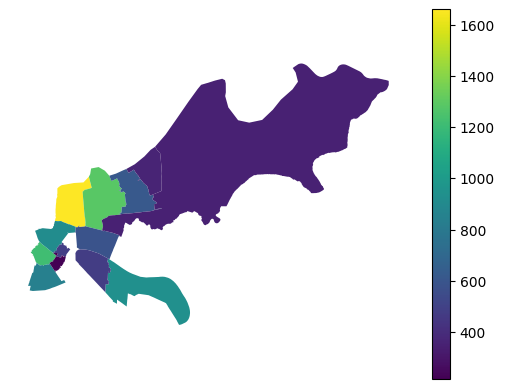

In [298]:
# Here's a choropleth of the data. I would put this on a slide with a Title and NOLAPS branding

nola_econ_dis.plot(column='Num Econ Disadv', 
                   legend=True
                   ).set_axis_off()

In [283]:
# This map is interactive if you're using a browser to view the HTML file!
# (it may look weird on PDF version, just wanted to include it because I think it's cool!)

nola_econ_dis.explore(column="Num Econ Disadv")

### Data Systems
#### 7) Assume the files are tables in a database. The table naming conventions are up to you. Write a SQL query to retrieve the number of available seats across all facilities in Cost Tier 1 and 2 except for those contained in Planning Districts 12, 13

This would be the SQL query if "planning_district" field only contains the numbers of the planning districts

SELECT SUM(available_seats)
FROM enrollment
WHERE (cost_tier IN (1,2) AND 
    planning_district NOT IN (12,13)
)

This would be the SQL query if "planning_district" field contains the words "Planning Districts 12, 13"
SELECT SUM(available_seats)
FROM enrollment
WHERE (cost_tier IN (1,2) AND
    planning_district NOT LIKE "Planning Districts 12, 13"
    )

#### 8) If you were to create tables for the data contained in these files, what keys would you use or create to make the data more manageable?

I would of course use the Site Code as a primary key since it is the most unique thing identifying each site. I would also make a key out of the concatenation of site code and grade level to be able to access data at the grade level.   

# THANK YOU FOR YOUR TIME! :)
# Anton Overby, antonoverby@gmail.com, 504-351-0538